In [111]:
# import sys
# !{sys.executable} -m pip install sklearn

In [112]:
# Import the required modules
import glob
import time
import os
from collections import defaultdict
import fdsreader as fds
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import solve_ivp
from matplotlib import cm

In [113]:

class windODE:
    def __init__(
            self,
            directory,
            fds_input_location,
            t_span,
            numberStreakLines
    ):
        """

        :param directory: location of the fds output files
        :param fds_input_location: location of the fds input file
        :param t_span: time frame for ODE to run over

        :vars self.sim: fdsreader object
        :vars self.fds_input_location: fds_input_location
        :vars self.t_span: t_span
        :vars self.__directory: directory
        :vars self.__qFiles: list of all plot 3d output files
        :vars self.__timeList: list of all plot 3d time dumps
        :vars self.__voxalSize: resolution of each voxal
        :vars self.__maxVelocity: maximum velocity of any particle in the streamlines
        :vars self.startingpoints: list of all starting points to be used in the ODE

        """

        self.sim = fds.Simulation(directory)
        self.fds_input_location = fds_input_location
        self.t_span = t_span
        self.__numberOfStreakLines = numberStreakLines
        self.__directory = directory
        self.__qFiles = glob.glob(directory + "*.q")
        self.__timeList = np.array(self.sim.data_3d.times)
        self.__voxalSize = {}
        self.__maxVelocity = 0.0
        self.__maxRe = 0.0
        self.__REDict=defaultdict(lambda : [])
        self.startingpoints = []
        self.__meshBounds = self.sim.meshes[0]
        self.__meshExtent = self.sim.meshes[0].extent

        self.getVoxalSize()

    def getVoxalSize(self):
        """
        Calculates voxal size
        :return:
        """

        self.__voxalSize["vx"] = (self.__meshExtent.x_end - self.__meshExtent.x_start) / (
                self.__meshBounds.dimension["x"] - 1
        )
        self.__voxalSize["vz"] = (self.__meshExtent.z_end - self.__meshExtent.z_start) / (
                self.__meshBounds.dimension["z"] - 1
        )
        self.__voxalSize["vy"] = (self.__meshExtent.y_end - self.__meshExtent.y_start) / (
                self.__meshBounds.dimension["y"] - 1
        )
        return self

    def getPositionFromIndex(self,x):
        x_index = x[0]
        y_index = x[1]
        z_index = x[2]
        x_position = self.__meshExtent.x_start + x_index*self.__voxalSize["vx"]
        y_position = self.__meshExtent.y_start + y_index*self.__voxalSize["vy"]
        z_position = self.__meshExtent.z_start + z_index*self.__voxalSize["vz"]
        return [x_position,y_position,z_position]

    def getStartingPoints(self):

        """
        Creates a list of points  on the outer most voxals of OBSTS, one point per voxal
        :var X_Min_Value center point of minimum x voxal
        :var X_Max_Value center point of maximum x voxal
        :var Y_Min_Value center point of minimum y voxal
        :var Y_Max_Value center point of maximum y voxal

        :return:
        """
        X_Min_Value = (
                self.__meshExtent.x_start + self.__voxalSize["vx"] / 2.0
        )
        X_Max_Value = (
                self.__meshExtent.x_end - self.__voxalSize["vx"] / 2.0
        )
        Y_Min_Value = (
                self.__meshExtent.y_start + self.__voxalSize["vy"] / 2.0
        )
        Y_Max_Value = (
                self.__meshExtent.y_end - self.__voxalSize["vy"] / 2.0
        )
        with open(self.fds_input_location) as f:
            lines = f.readlines()

        lineCounter = 0
        while lineCounter < len(lines):
            current_line = lines[lineCounter]
            if current_line == "\n":
                lineCounter += 1
                continue
            while "/" not in lines[lineCounter]:
                lineCounter += 1
                current_line = current_line + lines[lineCounter]

            lineCounter += 1
            if "&OBST" not in current_line:
                continue
            mesh_line = current_line.replace("/", "").replace("\n", "")
            XB = [float(point) for point in mesh_line.split("XB=")[1].split(",")[:6]]

            if XB[0] <= X_Min_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )

            if XB[0] <= X_Max_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )
            if XB[2] <= Y_Min_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )
            if XB[2] <= Y_Max_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )

        return self

    def filterOutStreamsByLength(self):
        """
        This function removes all streamlines that total distance traveled is below a desired length.
        :return:
        """
        self.filteredTImeResults = {}

        self.distanceofWindStreams_index = defaultdict(lambda: [])
        allData = self.timeReasults
        for time in allData.keys():

            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            for i in range(numberofWindstreams):
                distanceofWindStream = 0
                for j in range(1, len(data[i]["y"][0])):
                    point1 = np.array(
                        (
                            data[i]["y"][0][j - 1],
                            data[i]["y"][1][j - 1],
                            data[i]["y"][2][j - 1],
                        )
                    )
                    point2 = np.array(
                        (data[i]["y"][0][j], data[i]["y"][1][j], data[i]["y"][2][j])
                    )
                    p1_p2_distance = np.linalg.norm(point1 - point2)
                    distanceofWindStream += p1_p2_distance

                if distanceofWindStream > np.min(list(self.__voxalSize.values())) * 2.0:
                    self.distanceofWindStreams_index[time].append(i)

    def startingPointsRibbon(self, starting_pont, ending_point, number_of_points):
        x_ = np.linspace(starting_pont[0], ending_point[0], number_of_points)
        y_ = np.linspace(starting_pont[1], ending_point[1], number_of_points)
        z_ = np.linspace(starting_pont[2], ending_point[2], number_of_points)
        points = np.stack((x_.flatten(), y_.flatten(), z_.flatten()), axis=1)

        self.startingpoints.extend(points)
        return self

    def runODE(self,time_step_index,reverse_integration=False):
        t_span = [
            min(self.__timeList[time_step_index:]),
            max(self.__timeList[time_step_index:]),
        ]
        current_results=[]

        if reverse_integration:
            t_span[1] = 0.0

        for startCounter in range(len(self.startingpoints)):
            y0 = self.startingpoints[startCounter]

            result_solve_ivp = solve_ivp(
                self.get_velocity, t_span, y0,
                # rtol=1E-4, atol=1E-6,
            )
            result_with_velocity = self.addVelocity(result_solve_ivp)
            current_result_max_vel = np.max(result_with_velocity["velocity"])
            if self.__maxVelocity < current_result_max_vel:
                print(
                    f"new max Velocity {current_result_max_vel} changed from {self.__maxVelocity}"
                )
                self.__maxVelocity = current_result_max_vel

            result_with_re = self.addReynoldsNumber(result_with_velocity)
            current_result_max_re = np.max(result_with_re["re"])
            self.__REDict[self.__timeList[time_step_index]].append(current_result_max_re)
            if self.__maxRe < current_result_max_re:
                print(
                    f"new max RE {current_result_max_re} changed from {self.__maxRe}"
                )
                self.__maxRe = current_result_max_re
            current_results.append(result_with_re)
        return current_results

    def StartODE(self, reverse_integration=True):

        self.timeReasults = {}
        for t_start in self.__timeList:
            if t_start > self.t_span[1] or t_start < self.t_span[0]:
                continue

            time_step_index = self.__GetClosestTimeStepIndex(t_start)

            all_results=self.runODE(time_step_index)
            if reverse_integration:
                backward = self.runODE(time_step_index,True)
                all_results= self.combineODEFrames(all_results,backward)
            self.timeReasults[t_start] = all_results

        return self

    def combineODEFrames(self, all_forward_data,all_backwards_data):
        return_values = all_backwards_data
        for i in range(len(all_backwards_data)):
            backwards_data = all_backwards_data[i]
            forward_data = all_forward_data[i]
            return_values[i]['t'] = backwards_data['t'][::-1]
            return_values[i]['y'][0] = backwards_data['y'][0][::-1]
            return_values[i]['y'][1] = backwards_data['y'][1][::-1]
            return_values[i]['y'][2] = backwards_data['y'][2][::-1]
            return_values[i]['velocity'] = backwards_data['velocity'][::-1] * -1
            return_values[i]['re'] = backwards_data['re'][::-1]


            return_values[i]['t']= np.concatenate((backwards_data['t'], forward_data['t'][1:]))
            print(return_values[i]['y'][0])
            print(forward_data['y'][0])
            y_=[np.concatenate((backwards_data['y'][0],forward_data['y'][0][1:])),
              np.concatenate((backwards_data['y'][1],forward_data['y'][1][1:])),
              np.concatenate((backwards_data['y'][2],forward_data['y'][2][1:]))]
            return_values[i]['y']=y_
            return_values[i]['velocity']=np.concatenate((backwards_data['velocity'],forward_data['velocity'][1:]))

            return_values[i]['re']=np.concatenate((backwards_data['re'], forward_data['re'][1:]))

        return return_values


    def write2bin(self, desired_directory, file_name_prefix):
        fileName = os.path.join(desired_directory, file_name_prefix)
        allData = self.timeReasults
        maxVel = self.__maxVelocity
        print(f"Max {maxVel}")
        for time in allData.keys():
            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            time_string = f"{time}".split(".")[1]
            with open(f"{fileName}_{int(time)}_{time_string}.binwind", "wb") as outfile:

                np.ndarray.tofile(np.array([maxVel], dtype=np.float32), outfile)
                np.ndarray.tofile(np.array([numberofWindstreams], dtype=int), outfile)
                np.ndarray.tofile(np.array(lengthofWindStreams, dtype=int), outfile)

                for i in range(numberofWindstreams):
                    currentStream = []
                    for j in range(len(data[i]["y"][0])):
                        currentStream.append(
                            [
                                data[i]["t"][j],
                                data[i]["velocity"][j],
                                data[i]["y"][0][j],
                                data[i]["y"][1][j],
                                data[i]["y"][2][j],
                            ]
                        )

                    np.ndarray.tofile(
                        np.array(currentStream, dtype=np.float32), outfile
                    )
                print(fileName, "saved")
        return self

    def get_velocity(self, t, x):

        counter = self.__GetClosestTimeStepIndex(t)
        plt_3d_data = self.sim.data_3d[counter]

        mesh = self.sim.meshes[0]
        # Select a quantity
        uvel_idx = plt_3d_data.get_quantity_index("U-VEL")
        vvel_idx = plt_3d_data.get_quantity_index("V-VEL")
        wvel_idx = plt_3d_data.get_quantity_index("W-VEL")
        index_values = self.get_index_values(x)
        u_vel_data = plt_3d_data[mesh].data[:, :, :, uvel_idx]
        u_velocity = u_vel_data[index_values[0], index_values[1], index_values[2]]
        v_vel_data = plt_3d_data[mesh].data[:, :, :, vvel_idx]
        v_velocity = v_vel_data[index_values[0], index_values[1], index_values[2]]
        w_vel_data = plt_3d_data[mesh].data[:, :, :, wvel_idx]
        w_velocity = w_vel_data[index_values[0], index_values[1], index_values[2]]

        return np.array([u_velocity, v_velocity, w_velocity])

    def get_index_values(self, x):
        x_index = (x[0] - self.__meshExtent.x_start) / self.__voxalSize["vx"]
        if 0 > x_index or x_index > self.__meshBounds.dimension["x"]:
            return np.array([0, 0, 0], dtype=int)
        y_index = (x[1] - self.__meshExtent.y_start) / self.__voxalSize["vy"]
        if 0 > y_index or y_index > self.__meshBounds.dimension["y"]:
            return np.array([0, 0, 0], dtype=int)
        z_index = (x[2] - self.__meshExtent.z_start) / self.__voxalSize["vz"]
        if 0 > z_index or z_index > self.__meshBounds.dimension["z"]:
            return np.array([0, 0, 0], dtype=int)
        return np.array([x_index, y_index, z_index], dtype=int)

    def addReynoldsNumber(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allRe = []  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        for i in range(len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            currentTime = allTimes[i]
            allRe.append(self.__GetReynoldsNumber(currentPosition, currentTime))

        oneDataSet["re"] = np.array(allRe)
        return oneDataSet

    def addVelocity(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allSpeeds = [0.0]  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        previousPosition = np.array(
            [allPositions[0][0], allPositions[1][0], allPositions[2][0]]
        )
        for i in range(1, len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            deltaTime = allTimes[i] - allTimes[i - 1]
            squared_dist = np.sum((currentPosition - previousPosition) ** 2, axis=0)
            dist = np.sqrt(squared_dist)
            if dist ==0.0 or deltaTime ==0.0:
                speed=0.0
            else:
                speed = dist / deltaTime
            allSpeeds.append(speed)
            previousPosition = currentPosition

        oneDataSet["velocity"] = np.array(allSpeeds)
        return oneDataSet

    def drawPlot(self):
        for time in self.distanceofWindStreams_index.keys():
            data = self.timeReasults[time]
            maxRE= np.max(np.array(self.__REDict[time]))
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(1, 1, 1, projection="3d")
            for i in self.distanceofWindStreams_index[time]:
                print(data[i]['t'])
                x = data[i]["y"][0][:]
                y = data[i]["y"][1][:]
                z = data[i]["y"][2][:]
                re = data[i]["re"][:]

                temp =np.max(re)/maxRE
                ax.plot(x, y, z,  c=cm.viridis(temp))
            plt.show()


    def __GetClosestTimeStepIndex(self, t):
        closest_timeStep_value = min(self.__timeList, key=lambda x: abs(x - t))
        closest_timeStep_index = np.where(self.__timeList == closest_timeStep_value)[0][0]
        return int(closest_timeStep_index)

    def __GetReynoldsMatrix(self, t):
        time_step_index = self.__GetClosestTimeStepIndex(t)
        plt_3d_data = self.sim.data_3d[time_step_index]

        mesh = self.sim.meshes[0]
        # Select a quantity
        try:
            dxeta_idx = plt_3d_data.get_quantity_index("dx/eta")
        except:
            print("dx/eta plot 3d data ot found ")
            return []

        re_data = plt_3d_data[mesh].data[:, :, :, dxeta_idx]

        return re_data

    def __GetReynoldsNumber(self, x, t):
        re_data = self.__GetReynoldsMatrix(t)
        if len(re_data)==0:
            return

        index_values = self.get_index_values(x)
        re_value = re_data[index_values[0], index_values[1], index_values[2]]

        return re_value

    def EvaluateReynoldsValues(self):
        values = defaultdict(lambda : 0)
        for t in self.__timeList[3:10]:
            current_Re_values = self.__GetReynoldsMatrix(t)
            flatten_values =flatten_values_sorted  = np.array(current_Re_values,dtype=np.float64).flatten()
            flatten_values_sorted= list(np.sort(flatten_values_sorted))
            Re_percentile_min = np.percentile(flatten_values,86.5)
            ranking = {}
            for i in range(len(flatten_values_sorted)):
                ranking[flatten_values[i]]=i

            for i in range(current_Re_values.shape[0]):
                for j in range(current_Re_values.shape[1]):
                    for k in range(current_Re_values.shape[2]):
                        if current_Re_values[i,j,k] >=Re_percentile_min:
                            values[f"{i},{j},{k}"] += current_Re_values[i,j,k]

        print(np.max(list(values.values())))
        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")
        max_value = np.percentile(list(values.values()),70)
        x=[]
        y=[]
        z=[]
        c=[]
        for key in list(values.keys()):
            if values[key]< max_value:
                continue
            x_k,y_k,z_k = key.split(',')
            x.append(int(x_k))
            y.append(int(y_k))
            z.append(int(z_k))
            value = float(values[key])
            c.append(value)

        # Creating color map
        my_cmap = plt.get_cmap('viridis')

        scatter_plot=ax.scatter3D(x,y,z,c=c,cmap=my_cmap)

        plt.colorbar(scatter_plot)

        plt.show()

        highest_re_Points = []
        c_sorted = sorted(c)
        for i in range(len(c)):
            highest_re_Points.append(c.index(c_sorted[i]))

        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")
        x_1 = []
        y_1 = []
        z_1 = []
        c_1 = []
        for key in highest_re_Points[self.__numberOfStreakLines*-1:]:
            x_1.append(x[key])
            y_1.append(y[key])
            z_1.append(z[key])
            value = float(c[key])
            c_1.append(value)

        # Creating color map
        my_cmap = plt.get_cmap('viridis')
        scatter_plot = ax.scatter3D(x_1, y_1, z_1, c=c_1, cmap=my_cmap)
        plt.colorbar(scatter_plot)
        plt.show()

        points_of_interest_index = [ [x_1[i],y_1[i],z_1[i]] for i in range(len(x_1))]
        points_of_interest_position = [ self.getPositionFromIndex([x_1[i],y_1[i],z_1[i]]) for i in range(len(x_1))]
        for i in range(len(points_of_interest_position)):
            print(points_of_interest_index[i],points_of_interest_position[i])

        self.startingpoints.extend(points_of_interest_position)


    def getDataFromTime(self,t):
        if t in self.timeReasults.keys():
            return self.timeReasults[t]
        return []

    def getMaxRE(self):
        return self.__maxRe

    def getReynoldsMatrix(self,t):
        return self.__GetReynoldsMatrix(t)
    def getTimeList(self):
        return self.__timeList



13173.416259765625


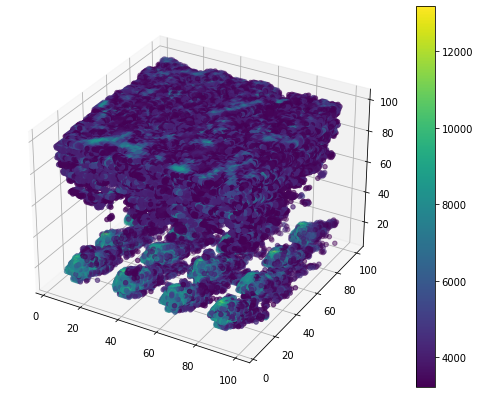

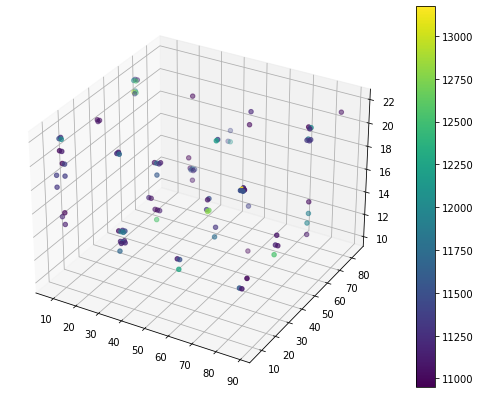

[11, 9, 20] [2.2, 1.8, 4.0]
[35, 57, 17] [7.0, 11.4, 3.4000000000000004]
[12, 8, 16] [2.4000000000000004, 1.6, 3.2]
[84, 60, 22] [16.8, 12.0, 4.4]
[60, 59, 10] [12.0, 11.8, 2.0]
[10, 9, 21] [2.0, 1.8, 4.2]
[35, 60, 22] [7.0, 12.0, 4.4]
[60, 59, 21] [12.0, 11.8, 4.2]
[9, 35, 21] [1.8, 7.0, 4.2]
[88, 9, 15] [17.6, 1.8, 3.0]
[86, 58, 16] [17.2, 11.600000000000001, 3.2]
[36, 33, 15] [7.2, 6.6000000000000005, 3.0]
[10, 35, 21] [2.0, 7.0, 4.2]
[85, 84, 21] [17.0, 16.8, 4.2]
[35, 33, 15] [7.0, 6.6000000000000005, 3.0]
[35, 33, 19] [7.0, 6.6000000000000005, 3.8000000000000003]
[36, 7, 16] [7.2, 1.4000000000000001, 3.2]
[34, 32, 16] [6.800000000000001, 6.4, 3.2]
[36, 58, 15] [7.2, 11.600000000000001, 3.0]
[87, 32, 16] [17.400000000000002, 6.4, 3.2]
[57, 34, 17] [11.4, 6.800000000000001, 3.4000000000000004]
[35, 58, 16] [7.0, 11.600000000000001, 3.2]
[37, 34, 19] [7.4, 6.800000000000001, 3.8000000000000003]
[87, 33, 15] [17.400000000000002, 6.6000000000000005, 3.0]
[85, 59, 13] [17.0, 11.8, 2.6]

In [114]:



fds_loc = "/home/trent/Trunk/Trunk/Trunk.fds"
dir = "/home/trent/Trunk/Fire"
# fds_loc = "/home/kl3pt0/Trunk/Trunk/Trunk.fds"
# dir = "/home/kl3pt0/Trunk/Fire"
#
# fds_loc = "E:\Trunk\Trunk\Trunk\Trunk.fds"
# dir = "E:\Trunk\Trunk\\temp\\"

t_span = [15,16]
start_time = time.perf_counter()
app = windODE(dir, fds_loc, t_span,100)
app.EvaluateReynoldsValues()


# app.getStartingPoints()
# app.startingPointsRibbon([19, 1, 3.5], [1, 19, 3.5], 40)
# app.startingpoints = [[10,10,3]]
# app.StartODE(reverse_integration=True)
#
# app.filterOutStreamsByLength()
# app.write2bin("data","temp")

print(f"Total Time {time.perf_counter()-start_time:0.4f}")
# app.drawPlot()
print()

In [115]:
t_start = 0
t_end= 60

allTimelist = app.getTimeList()
filteredTimeList = allTimelist[allTimelist>=t_start]
filteredTimeList = filteredTimeList[filteredTimeList<=t_end]
print(filteredTimeList)

testData = app.getReynoldsMatrix(filteredTimeList[0])
for i in range(1,len(filteredTimeList)):
    testData = testData + app.getReynoldsMatrix(filteredTimeList[i])
testData = testData/len(filteredTimeList)


[ 0.5   1.    1.51  2.    2.5   3.    3.51  4.1   4.5   5.    5.5   6.
  6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
 12.5  13.   13.51 14.1  14.5  15.   15.5  16.   16.5  17.   17.5  18.
 18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.
 24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.
 30.5  31.   31.5  32.   32.51 33.   33.5  34.   34.5  35.   35.5  36.
 36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.1
 42.5  43.   43.5  44.   44.51 45.   45.5  46.   46.5  47.   47.5  48.
 48.5  49.   49.5  50.   50.51 51.   51.5  52.   52.5  53.1  53.5  54.
 54.5  55.   55.5  56.1  56.5  57.   57.51 58.   58.5  59.1  59.5  60.  ]


(101, 101, 101)
Min non Zero Value 44.19196764628092
Standard Dev 248.95716755342335
Mean 600.3911363552785
2 sigma 1098.3054714621253
Standard Dev 157.44676463863013
Mean 666.4256167810765
2 sigma 981.3191460583369
[98.93601031366984 235.7961169821421 363.53221653938294 473.02030187416074
 710.2444867661793 1029.5847356592813 1129.9488138828278 1230.312892106374
 1339.8009774411519 1431.0410485534667 1531.405126777013 1640.893212111791
 1750.3812974465686]


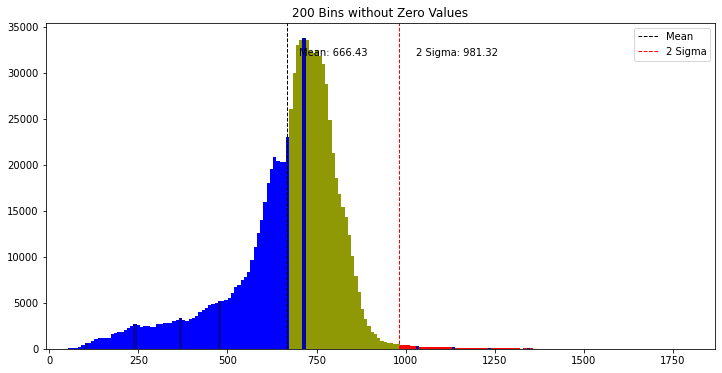

In [125]:
n_bins = 200

print(np.array(testData).shape)
testDataFlatten = np.array(testData).flatten()
testNoZero = testDataFlatten[testDataFlatten>0.0]

print(f"Min non Zero Value {np.min(testNoZero)}")

testMean = np.mean(testDataFlatten)
testStd = np.std(testDataFlatten)
print(f"Standard Dev {testStd}")
print(f"Mean {testMean}")
print(f"2 sigma {testMean+2*testStd}")
testN0Mean = np.mean(testNoZero)
testN0Std = np.std(testNoZero)
print(f"Standard Dev {testN0Std}")
print(f"Mean {testN0Mean}")
print(f"2 sigma {testN0Mean+2*testN0Std}")



# fig, ax = plt.subplots(figsize=(12, 6))
# plt.title(f"{n_bins} Bins Including Zero Values")
# plt.xlim([-10,np.max(testData)])
# n,bins,patches= plt.hist(testDataFlatten,color='pink', bins=n_bins)
#
# peaks, _ = find_peaks(n)
# print(bins[peaks])
# plt.axvline(testMean, color='k', linestyle='dashed', linewidth=1,label="Mean")
# plt.axvline(testMean+2*testStd, color='r', linestyle='dashed', linewidth=1,label="2 Sigma")
# min_ylim, max_ylim = plt.ylim()
# plt.text(testMean*1.05, max_ylim*0.9, 'Mean: {:.2f}'.format(testMean))
# plt.text((testMean+2*testStd)*1.05, max_ylim*0.9, '2 Sigma: {:.2f}'.format(testMean+2*testStd))
# ax.legend()
# for patch_i in range(len(patches)):
#
#     if bins[patch_i]<testMean+2*testStd:
#         patches[patch_i].set_fc("green")
#     if bins[patch_i]<testMean:
#         patches[patch_i].set_fc("blue")
#
# plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

plt.title(f"{n_bins} Bins without Zero Values")
plt.xlim([-10,np.max(testData)])

n,bins,patches=plt.hist(testNoZero, bins=n_bins)

peaks, _ = find_peaks(n,distance=10)
print(bins[peaks])
plt.axvline(testN0Mean, color='k', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(testN0Mean+2*testN0Std, color='r', linestyle='dashed', linewidth=1,label="2 Sigma")
min_ylim, max_ylim = plt.ylim()
plt.text(testN0Mean*1.05, max_ylim*0.9, 'Mean: {:.2f}'.format(testN0Mean))
plt.text((testN0Mean+2*testN0Std)*1.05, max_ylim*0.9, '2 Sigma: {:.2f}'.format(testN0Mean+2*testN0Std))
ax.legend()
for patch_i in range(len(patches)):
    patches[patch_i].set_fc("red")
    if bins[patch_i]<testN0Mean+2*testN0Std:
        patches[patch_i].set_fc("xkcd:baby poop green")
    if bins[patch_i]<testN0Mean:
        patches[patch_i].set_fc("blue")
    if patch_i in peaks:
        patches[patch_i].set_fc("xkcd:royal blue")
plt.show()




### The Reynolds number is defined as

    Re = uL/ν = ρuL/μ 

where:

    ρ is the density of the fluid (SI units: kg/m3)
    u is the flow speed (m/s)
    L is a characteristic linear dimension (m) (see the below sections of this article for examples)
    μ is the dynamic viscosity of the fluid (Pa·s or N·s/m2 or kg/(m·s))
    ν is the kinematic viscosity of the fluid (m2/s).

### The Dynamic viscocity coefficient is defined as

    μ = μo*(a/b)*(T/To)3/2

    a = 0.555To + C
    b = 0.555T + C

where

    μ  = viscosity in centipoise at input temperature T    
    μ0 = reference viscosity in centipoise at reference temperature To 0.01827
    T   = input temperature in degrees Rankine
    T0 = reference temperature in degrees Rankine 524.07
    C  = Sutherland's constant  = 120